# Fake News Detection Using Machine Learning Models

This notebook aims to classify fake news from real news.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Machine Learning
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer # Import for transforming text into numerical features using TF-IDF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Text processing
from wordcloud import WordCloud  # Import for generating word clouds

# Mounting Google Drive
from google.colab import drive  # Import for accessing Google Drive

# Unzipping files
import zipfile  # Import for extracting zip files

Read the data

In [2]:
# Mount your Google Drive
drive.mount('/content/drive')

# Get the file path from Google Drive
file_path = '/content/drive/MyDrive/fake news/archive (2).zip'

# Unzip the file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    # Find the CSV files in the zip folder
    fake_path = zip_ref.extract('Fake.csv', '/content/')
    real_path = zip_ref.extract('True.csv', '/content/')

# Read the csv file from the url
fake_df = pd.read_csv(fake_path)
real_df = pd.read_csv(real_path)

# A way to delete rows with empty or null values
fake_df = fake_df[~fake_df.isna().any(axis=1)]
real_df = real_df[~real_df.isna().any(axis=1)]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Checking for null values

In [3]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [4]:
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

Checking for unique values for subject. We want both data frames to have a similar distribution.

In [5]:
fake_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [6]:
real_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

Drop the date from the dataset, I don't think there is a strong correlation between date and validity of the news. As we see above, subjects are not distributed evenly. We do not want that to influence the accuracy of our classifier. Therefore, we need to drop that as well.

In [7]:
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

0 for fake news, and 1 for real news

In [8]:
fake_df['class'] = 0
real_df['class'] = 1

## EDA

Check out the distribution of fake news compare to real news

Text(0, 0.5, 'Proportion of News Articles')

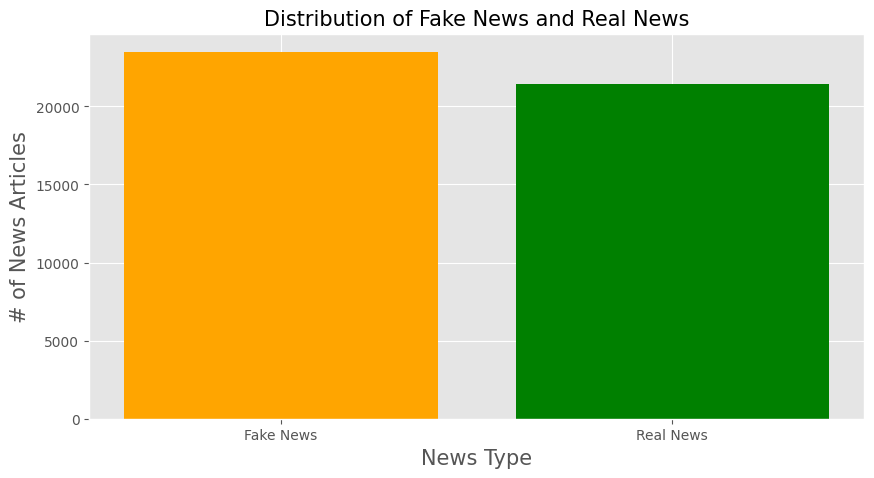

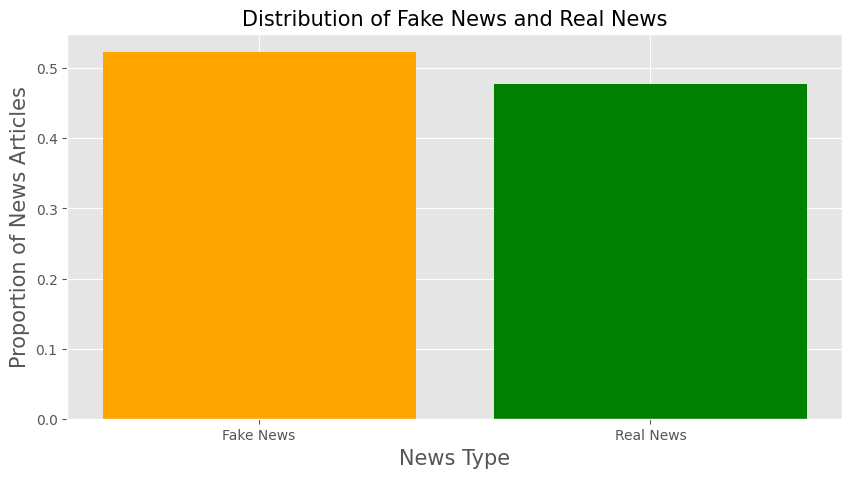

In [9]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)


total_len = len(fake_df) + len(real_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df) / total_len, color='orange')
plt.bar('Real News', len(real_df) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

In [10]:
print('Difference in news articles:',len(fake_df)-len(real_df))

Difference in news articles: 2064


In [11]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df

,title,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0
...,...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,1


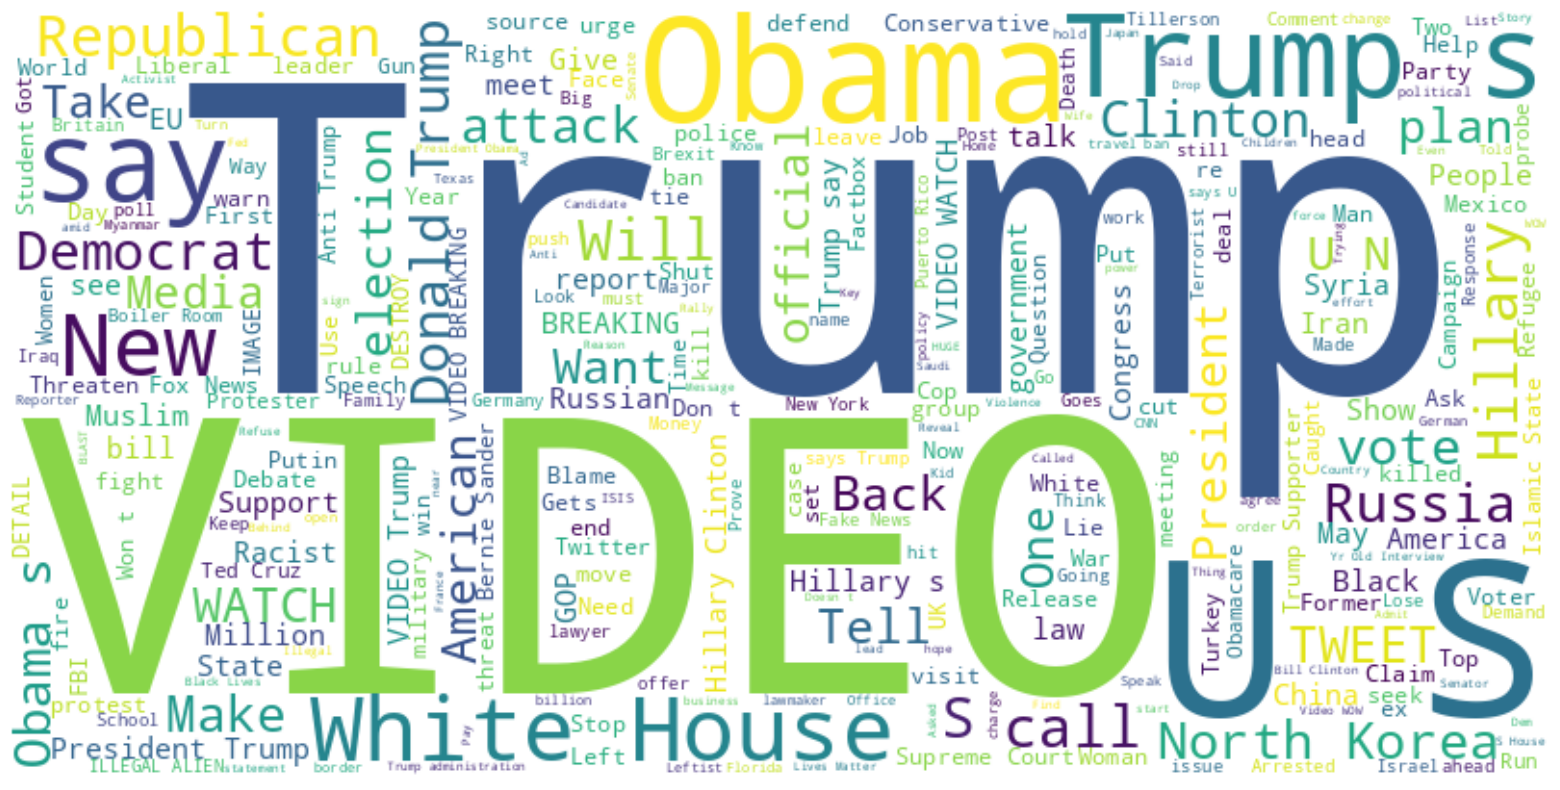

In [12]:
# Concatenate all the titles from the 'title' column in the DataFrame into a single string
titles = ' '.join(title for title in news_df['title'])

# Create a WordCloud object with specified configurations
wordcloud = WordCloud(
    background_color='white',  # Set the background color of the word cloud to white
    max_words=300,  # Set the maximum number of words to be displayed in the word cloud
    width=800,  # Set the width of the word cloud figure
    height=400  # Set the height of the word cloud figure
).generate(titles)  # Generate the word cloud based on the concatenated titles

# Display the word cloud figure
plt.figure(figsize=(20, 10))  # Set the size of the figure to display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')  # Display the word cloud with bilinear interpolation
plt.axis("off")  # Turn off the axis labels and ticks
plt.show()  # Show the word cloud figure

In [13]:
news_df['num_words'] = news_df['text'].apply(lambda x: len(x.split()))

<ipython-input-14-f4a93ea9bb73>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(news_df['num_words'], bins = range(1, 3000, 50), palette = 'Set1', alpha = 0.8)


Text(0.5, 1.0, 'Distribution of the News Words count')

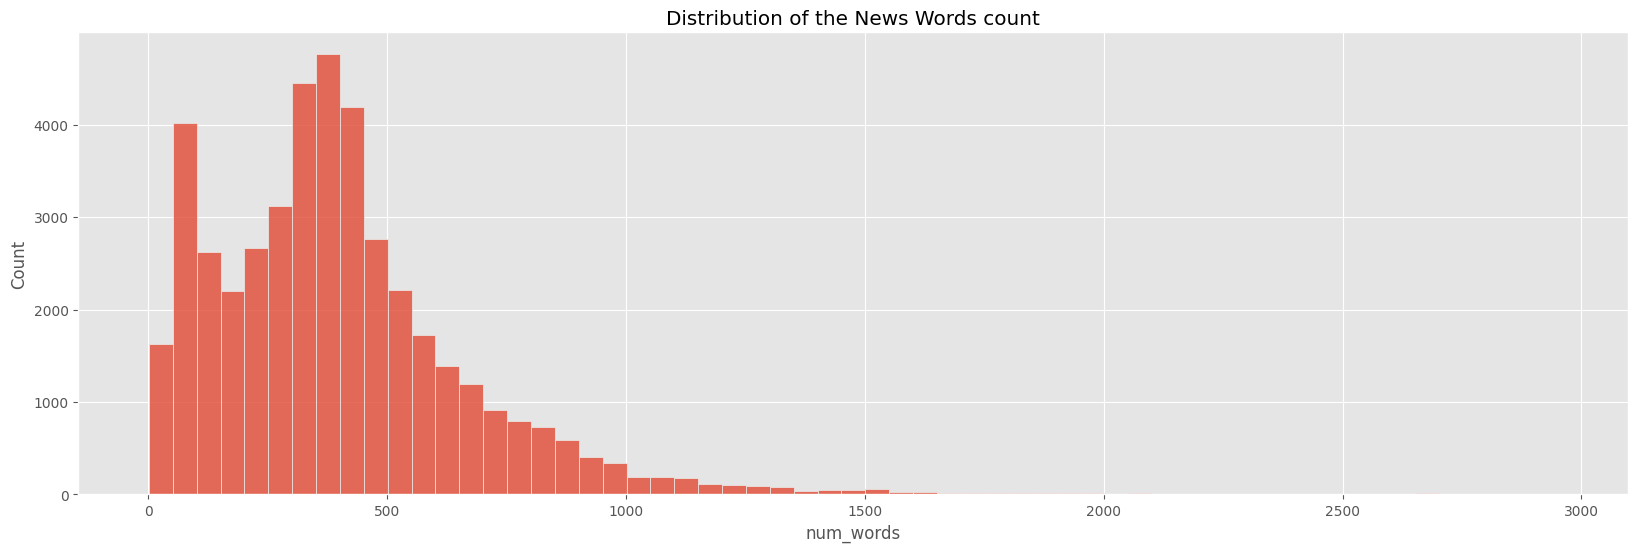

In [14]:
plt.figure(figsize = (20,6))
sns.histplot(news_df['num_words'], bins = range(1, 3000, 50), palette = 'Set1', alpha = 0.8)
plt.title('Distribution of the News Words count')

Combining the title with the text, it is much easier to process this way.

In [15]:
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

Split into training and testing

In [16]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

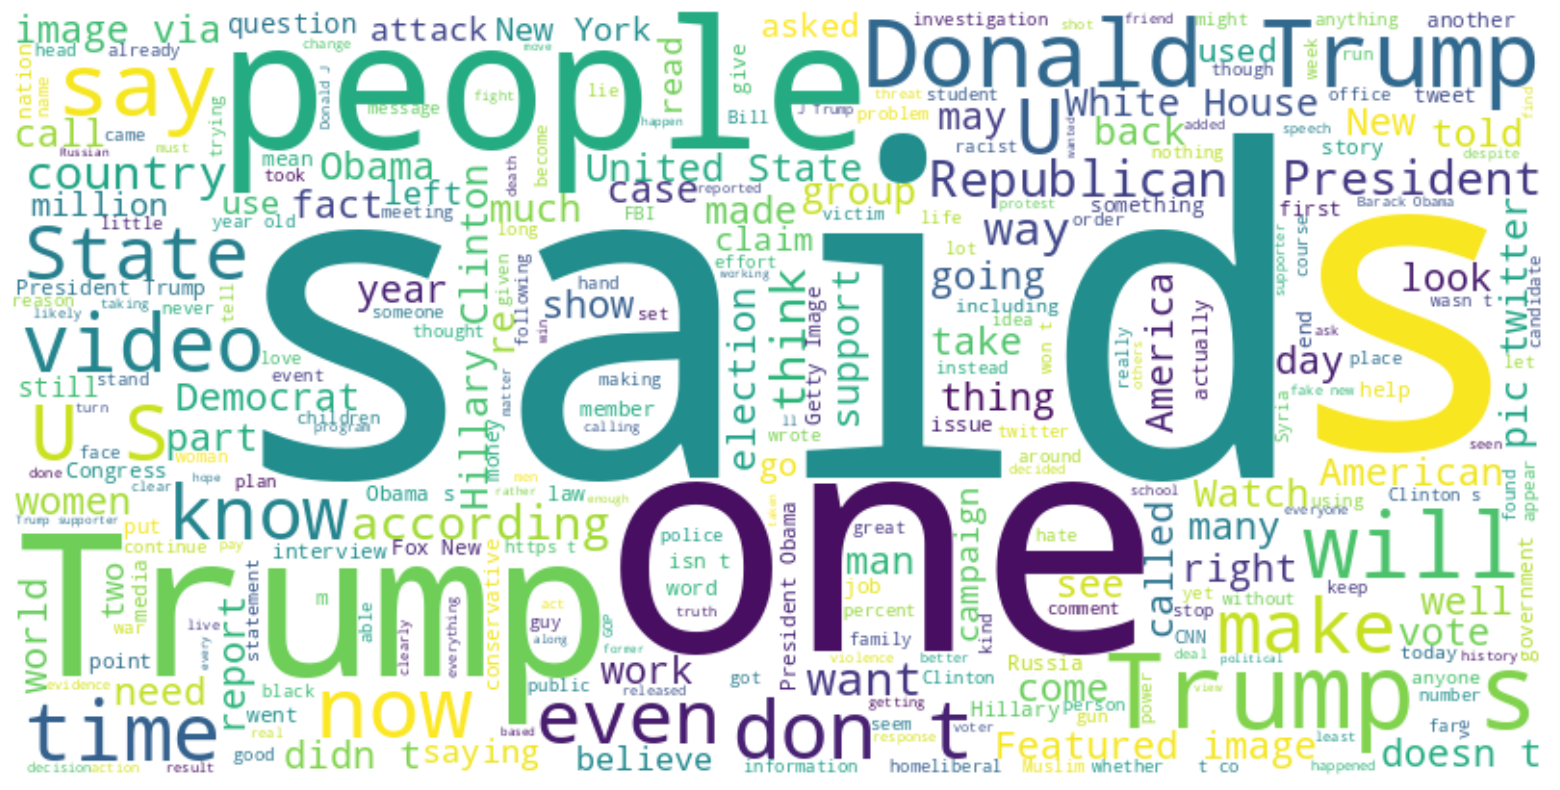

In [17]:
fake_news = X_train[y_train == 0]
real_news = X_train[y_train == 1]
fake_texts = ' '.join(text for text in fake_news)
wordcloud = WordCloud(
    background_color='white',
    max_words=300,
    width=800,
    height=400,
).generate(fake_texts)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The above is a plot of the most frequent words in fake news set

# Machine Learning

## Decision Tree

In [18]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

In [19]:
dt = DecisionTreeClassifier()

dt.fit(xv_train,y_train)

DecisionTreeClassifier()

In [20]:
pred=dt.predict(xv_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [21]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('F1 score on testing set:', f1_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.99543429844098
F1 score on testing set: 0.9952617589275395
Precision on testing set: 0.9972209356183418
Recall on testing set: 0.9933102652825836


## Random Forest Classifier

In [22]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(xv_train, y_train)

RandomForestClassifier(random_state=0)

In [23]:
rfc.score(xv_test, y_test)

0.9908685968819599

In [24]:
pred = rfc.predict(xv_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)

In [25]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('F1 score on testing set:', f1_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9908685968819599
F1 score on testing set: 0.990485031329775
Precision on testing set: 0.9884205650764243
Recall on testing set: 0.9925581395348837
